In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report ,roc_auc_score
from xgboost import XGBClassifier

In [6]:
fraud = pd.read_csv(r"C:\Users\Prathamesh\Downloads\Fraud.csv")
print(fraud.shape)
fraud.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
fraud.isFraud.mean()
# it shows 0.12% transactions are Fraud which is showing that the class is highly imbalanced

0.001290820448180152

In [9]:
# we drop (nameOrig , nameDest) --> because it is just ids and step --> it indicates hours and does not contribute to our model because our model isn't time dependent
fraud1 = fraud.drop(['step','nameOrig','nameDest'] , axis = 1)
fraud1.head(2)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0


In [10]:
fraud1.isnull().sum()[fraud1.isnull().sum() > 0]
# it shows that their is no null values

Series([], dtype: int64)

In [11]:
fraud1.select_dtypes(include = 'object').columns
# their is only one categorical column

Index(['type'], dtype='object')

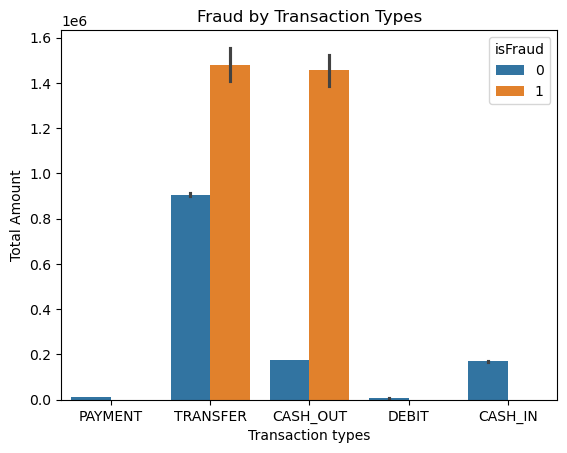

In [12]:
sns.barplot(x = 'type' , y = 'amount' , data = fraud1 ,hue = 'isFraud')
plt.title('Fraud by Transaction Types')
plt.xlabel('Transaction types')
plt.ylabel('Total Amount')
plt.show()
# it shows Fraud happens only in CASH_OUT and TRANSFER transaction Type 

{'whiskers': [<matplotlib.lines.Line2D at 0x240461558b0>,
 'caps': [<matplotlib.lines.Line2D at 0x240023293d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x24002328c50>],
 'medians': [<matplotlib.lines.Line2D at 0x24002329790>],
 'fliers': [<matplotlib.lines.Line2D at 0x24002329a60>],
 'means': []}

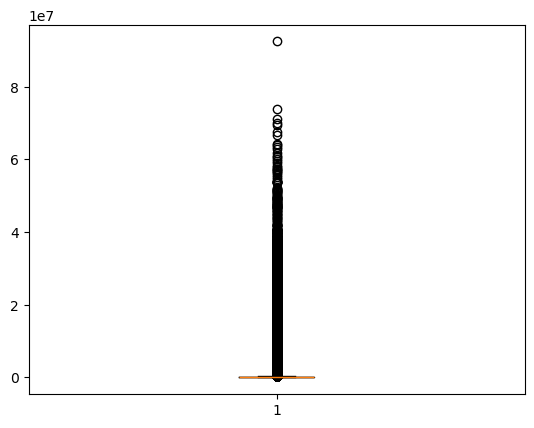

In [13]:
plt.boxplot(fraud1['amount'])
# outliers would be expected 
# it shows that very few account have large amount of money and Fraud usually lives in these large values

{'whiskers': [<matplotlib.lines.Line2D at 0x2400236f650>,
 'caps': [<matplotlib.lines.Line2D at 0x2400236fa70>,
 'boxes': [<matplotlib.lines.Line2D at 0x2400236f170>],
 'medians': [<matplotlib.lines.Line2D at 0x2400236ff50>],
 'fliers': [<matplotlib.lines.Line2D at 0x240023b01a0>],
 'means': []}

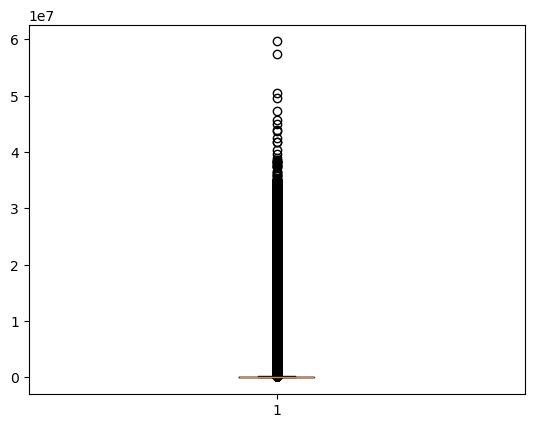

In [14]:
plt.boxplot(fraud1['oldbalanceOrg'])
# very few account have huge amount and fraudster target these account

{'whiskers': [<matplotlib.lines.Line2D at 0x240023ee900>,
 'caps': [<matplotlib.lines.Line2D at 0x240023eee70>,
 'boxes': [<matplotlib.lines.Line2D at 0x240023ed730>],
 'medians': [<matplotlib.lines.Line2D at 0x240023ef3b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x240023ef620>],
 'means': []}

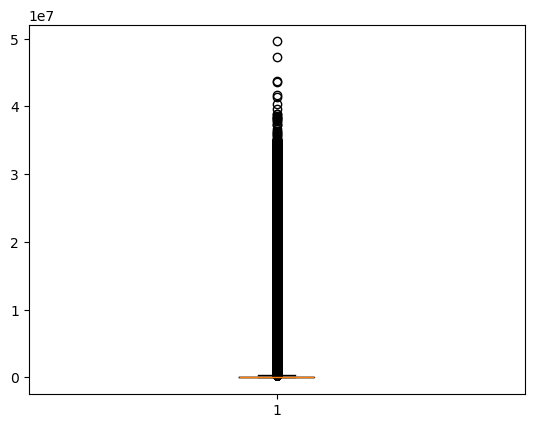

In [15]:
plt.boxplot(fraud1['newbalanceOrig'])
# very few account have huge amount and fraudster target these account

{'whiskers': [<matplotlib.lines.Line2D at 0x240025acc20>,
 'caps': [<matplotlib.lines.Line2D at 0x240025ad190>,
 'boxes': [<matplotlib.lines.Line2D at 0x240023b3dd0>],
 'medians': [<matplotlib.lines.Line2D at 0x240025ad5e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x240025ad8b0>],
 'means': []}

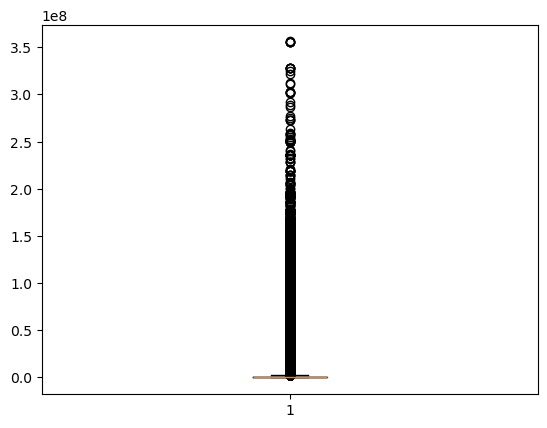

In [16]:
plt.boxplot(fraud1['oldbalanceDest'])
# many destination accounts are of merchants
# some destination accounts receive large amount of transfer

{'whiskers': [<matplotlib.lines.Line2D at 0x240026243e0>,
 'caps': [<matplotlib.lines.Line2D at 0x240026248f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x24002624140>],
 'medians': [<matplotlib.lines.Line2D at 0x24002624d70>],
 'fliers': [<matplotlib.lines.Line2D at 0x24002625040>],
 'means': []}

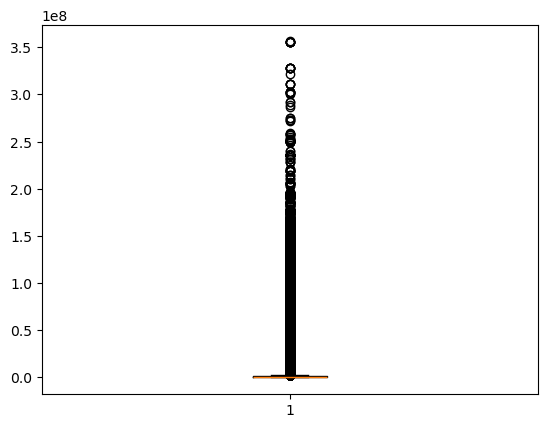

In [17]:
plt.boxplot(fraud1['newbalanceDest'])
# many destination accounts are of merchants
# some destination accounts receive large amount of transfer

In [18]:
y = fraud1['isFraud']
x = fraud1.drop(['isFraud'],axis = 1)

In [19]:
x.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [20]:
x = pd.get_dummies(x , columns = ['type'])
# one hot encoding

In [21]:
x_train, x_test , y_train , y_test = train_test_split(x , y , test_size = .2 , random_state = 555 ,stratify = y)
# split the data into train test

In [22]:
x_train.head(2)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2619459,23508.32,0.0,0.0,321577.22,508540.91,0,False,True,False,False,False
1805538,1943336.25,0.0,0.0,3348741.85,5292078.09,0,False,False,False,False,True


In [23]:
y_train.head(2)

2619459    0
1805538    0
Name: isFraud, dtype: int64

In [24]:
x_test.head(2)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
4640154,7294.48,0.00,0.00,0.00,0.00,0,False,False,False,True,False
5994121,152672.68,1173422.26,1326094.94,175286.68,22614.01,0,True,False,False,False,False


In [25]:
y_test.head(2)

4640154    0
5994121    0
Name: isFraud, dtype: int64

In [26]:
rfc = RandomForestClassifier(n_estimators=100,
                             class_weight='balanced', 
                             n_jobs=-1)
rfc.fit(x_train , y_train)
# build the model

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [27]:
pred = rfc.predict(x_test)
pred
# testing on unseen data

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [28]:
confusion_matrix(y_test , pred)

array([[1270839,      42],
       [    353,    1290]], dtype=int64)

In [29]:
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.97      0.79      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.89      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



In [30]:
roc_auc_score(y_test, pred)
# It means the model can effectively distinguish fraudulent transactions from legitimate ones across different decision thresholds and score is good

0.8925580347636435

In [31]:
pred_prob = rfc.predict_proba(x_test)
pred_prob
# It gives a fraud probability for each transaction

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [32]:
pred_prob[:900]
# One transaction it is slightly risky but not excatly fraud

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [0.95, 0.05],
       [1.  , 0.  ]])

In [33]:
(rfc.predict_proba(x_test)[:, 1] > 0.05).sum()
# check which transactions have fraud risk and how many transactions are crossed risk threshold

2590

In [34]:
threshold = 0.05
y_pred_custom = (pred_prob[:, 1] >= threshold).astype(int)
# Instead of using the default 0.5 threshold, I lowered the decision threshold to increase recall and capture more fraudulent transactions

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_custom))
# we able to increase the recall while trade-off with precision

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.58      0.97      0.72      1643

    accuracy                           1.00   1272524
   macro avg       0.79      0.98      0.86   1272524
weighted avg       1.00      1.00      1.00   1272524



In [36]:
Imp_feat = pd.DataFrame()
Imp_feat['Features'] = x_train.columns
Imp_feat['Importance'] = rfc.feature_importances_
Imp_feat = Imp_feat.sort_values('Importance' , ascending= False)
Imp_feat
# Feature importance shows how much each input variable contributed to the model’s decisions

,Features,Importance
1,oldbalanceOrg,0.338338
0,amount,0.181019
2,newbalanceOrig,0.165341
9,type_PAYMENT,0.071622
10,type_TRANSFER,0.069930
4,newbalanceDest,0.059157
3,oldbalanceDest,0.045511
6,type_CASH_IN,0.039811
7,type_CASH_OUT,0.028617
8,type_DEBIT,0.000541


In [37]:
xgb = XGBClassifier(n_estimators=300,
                    max_depth=6,
                    learning_rate=0.1,
                   eval_metric='auc')

In [38]:
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [39]:
xgb_pred = xgb.predict(x_test)

In [40]:
xgb_pred

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
confusion_matrix(y_test , xgb_pred)

array([[1270842,      39],
       [    395,    1248]], dtype=int64)

In [42]:
print(classification_report(y_test , xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.97      0.76      0.85      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.88      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



In [43]:
xgb_prob = xgb.predict_proba(x_test)[: , 1]
xgb_prob
# Fraud probability for each transaction

array([1.7311407e-07, 3.7035460e-07, 2.6764832e-07, ..., 2.6706368e-06,
       1.3010049e-07, 6.8899830e-08], dtype=float32)

In [44]:
threshold = 0.05
xgb_pred_cust = (xgb_prob >= threshold).astype(int)
xgb_pred_cust

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
confusion_matrix(y_test , xgb_pred_cust)

array([[1269387,    1494],
       [     37,    1606]], dtype=int64)

In [46]:
print(classification_report(y_test, xgb_pred_cust))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.52      0.98      0.68      1643

    accuracy                           1.00   1272524
   macro avg       0.76      0.99      0.84   1272524
weighted avg       1.00      1.00      1.00   1272524



In [47]:
roc_auc_score(y_test, xgb_prob)
# It means the model can effectively distinguish fraudulent transactions from legitimate ones across different decision thresholds and score is Excellent

0.9970722817500135

In [48]:
xgb.feature_importances_

array([0.03658218, 0.1847098 , 0.03521657, 0.00248463, 0.42769998,
       0.        , 0.00674206, 0.10581803, 0.        , 0.00662765,
       0.19411907], dtype=float32)

In [49]:
x_train.columns

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [50]:
Imp_feat = pd.DataFrame()
Imp_feat['Features'] = x_train.columns
Imp_feat['Importance'] = xgb.feature_importances_
Imp_feat = Imp_feat.sort_values('Importance' , ascending= False)
Imp_feat
# Feature importance shows how much each input variable contributed to the model’s decisions

,Features,Importance
4,newbalanceDest,0.427700
10,type_TRANSFER,0.194119
1,oldbalanceOrg,0.184710
7,type_CASH_OUT,0.105818
0,amount,0.036582
2,newbalanceOrig,0.035217
6,type_CASH_IN,0.006742
9,type_PAYMENT,0.006628
3,oldbalanceDest,0.002485
5,isFlaggedFraud,0.000000


In [51]:
import pickle

filename = "fraud_model.pkl"      # name of the pickle file
with open(filename, 'wb') as file:
    pickle.dump(xgb, file)

print("Model saved as:", filename)

Model saved as: fraud_model.pkl


In [102]:
import pickle

with open("fraud_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

print("Model loaded successfully")

Model loaded successfully


# Key Business Insights from Data 